In [ ]:
import argparse
import logging.config
import os
from collections import defaultdict

from dotenv import load_dotenv

from rescueclip.logging_config import LOGGING_CONFIG

logging.config.dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)
from pathlib import Path
import matplotlib.pyplot as plt
import time

import numpy as np
from typing import cast, Sequence, List, Any, Literal
import weaviate
from tqdm import tqdm
from weaviate.classes.query import Filter, MetadataQuery
from weaviate.collections.classes.types import Properties, WeaviateProperties
from weaviate.collections.classes.internal import Object
from weaviate.util import generate_uuid5, get_vector

from rescueclip import cuhk
from rescueclip.cuhk import SetNumToImagesMap
from rescueclip.ml_model import (
    CollectionConfig,
    CUHK_Apple_Collection,
    CUHK_Google_Siglip_Base_Patch16_224_Collection,
    CUHK_Google_Siglip_SO400M_Patch14_384_Collection,
    CUHK_laion_CLIP_ViT_bigG_14_laion2B_39B_b160k_Collection,
    CUHK_MetaCLIP_ViT_bigG_14_quickgelu_224_Collection,
    CUHK_ViT_B_32_Collection,
    CUHK_PDNA_Collection
)
from rescueclip.weaviate import WeaviateClientEnsureReady

load_dotenv()

%load_ext autoreload
%autoreload 2

/scratch3/atharva/anaconda3/envs/rescueCLIP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
collection_config = CUHK_PDNA_Collection
client = WeaviateClientEnsureReady().get_client()
collection = client.collections.get(collection_config.name)
QUERY_MAXIMUM_RESULTS = 200_000

number_of_objects: int = collection.aggregate.over_all(total_count=True).total_count # type: ignore
logger.info(f"Number of objects %s", number_of_objects)
assert (
    number_of_objects <= QUERY_MAXIMUM_RESULTS 
), "Ensure docker-compose.yml has QUERY_MAXIMUM_RESULTS to greater than 200_000 or the experiment's results may be inaccurate"

2025-02-24 03:16:34,025 [INFO] rescueclip.weaviate: Weaviate is ready
2025-02-24 03:16:34,029 [INFO] __main__: Number of objects 18596


In [3]:
# Train test split
logger.info("Retrieving the entire database into memory")
objects = collection.query.fetch_objects(
    limit=QUERY_MAXIMUM_RESULTS,
    include_vector=True,
    return_properties=True,
).objects
assert len(objects) == number_of_objects, "Expected the entire database to be retrieved"

objects.sort(key=lambda obj: (obj.properties["set_number"], obj.properties["file_name"]))

##### TEMPORARITY MAKE DATASET SMALLER
# objects = objects[:4*4] # 4 sets of 4 images each
#####

# (N, D)
X = np.array([obj.vector["embedding"] for obj in objects])
y_set_labels = np.array([obj.properties["set_number"] for obj in objects])
N = X.shape[0]
logger.info(f"N: {N}")
assert y_set_labels.shape[0] == N, "Expected the number of objects to match the number of set labels"

##### TEMPORARITY ASSERTIONS
# assert N == 4*4, "Expected 16 objects"
# assert y_set_labels.shape[0] == 4*4, "Expected 16 objects"
# assert (np.unique(y_set_labels) == np.array([1, 4, 8, 9])).all(), "Expected the set labels to be 0, 1, 2, 3, got {}".format(np.unique(y_set_labels))
#####

logger.info(f"X.shape: {X.shape}")
logger.info(f"y_set_labels.shape: {y_set_labels.shape}")

2025-02-24 03:16:34,096 [INFO] __main__: Retrieving the entire database into memory
2025-02-24 03:16:36,441 [INFO] __main__: N: 18596
2025-02-24 03:16:36,443 [INFO] __main__: X.shape: (18596, 512)
2025-02-24 03:16:36,443 [INFO] __main__: y_set_labels.shape: (18596,)


In [4]:
assert N % 2 == 0, "Can't evenly split the data into train and test sets"
# (N//2, D)
X_train_vectors = X[:N//2, :]
# (N//2, D)
X_test_vectors = X[N//2:, :]

logger.info(f"X_train_vectors.shape: {X_train_vectors.shape}")
logger.info(f"X_test_vectors.shape: {X_test_vectors.shape}")

2025-02-24 03:16:36,485 [INFO] __main__: X_train_vectors.shape: (9298, 512)
2025-02-24 03:16:36,486 [INFO] __main__: X_test_vectors.shape: (9298, 512)


In [5]:
from scipy.spatial.distance import cdist

X_train_distances = cdist(X_train_vectors, X_train_vectors, metric='cosine')
y_train_labels = y_set_labels[:N//2]

logger.info("X_train_distances.shape: {}".format(X_train_distances.shape))
logger.info("y_train_labels.shape: {}".format(y_train_labels.shape))

2025-02-24 03:17:14,396 [INFO] __main__: X_train_distances.shape: (9298, 9298)
2025-02-24 03:17:14,399 [INFO] __main__: y_train_labels.shape: (9298,)


In [6]:
print(f"{X_train_distances[:5, :5]=}")
print(f"{y_train_labels[:5]}")

X_train_distances[:5, :5]=array([[0.        , 0.22907307, 0.22743923, 0.23042421, 0.31853669],
       [0.22907307, 0.        , 0.30521017, 0.31607513, 0.38195621],
       [0.22743923, 0.30521017, 0.        , 0.15982663, 0.28928928],
       [0.23042421, 0.31607513, 0.15982663, 0.        , 0.22718102],
       [0.31853669, 0.38195621, 0.28928928, 0.22718102, 0.        ]])
[1 1 1 1 4]


In [7]:
X_test_distances = cdist(X_train_vectors, X_test_vectors, metric='cosine')
y_test_labels = y_set_labels[N//2:]

logger.info(f"X_test_distances.shape: {X_test_distances.shape}")
logger.info(f"y_test_labels.shape: {y_test_labels.shape}")

2025-02-24 03:17:51,763 [INFO] __main__: X_test_distances.shape: (9298, 9298)
2025-02-24 03:17:51,767 [INFO] __main__: y_test_labels.shape: (9298,)


In [8]:
try:
    del X
    del y_set_labels
except:
    pass

In [9]:
# For train data
sorted_indexes = np.argsort(X_train_distances, axis=1)
print(f"{sorted_indexes[:8, :8]=}")
assertion_cond = (np.arange(N//2) == sorted_indexes[:, 0])
if not np.all(assertion_cond):
    false_indices = np.flatnonzero(~assertion_cond)
    logger.info(f"Fixing distances at positions: {false_indices}")
    for false_index in false_indices:
        logger.info(f"Swapping index: {false_index}")
        temp = sorted_indexes[false_index, 0]
        sorted_indexes[false_index, 0] = sorted_indexes[false_index, 1]
        sorted_indexes[false_index, 1] = temp
    assertion_cond = (np.arange(N//2) == sorted_indexes[:, 0])
    if not np.all(assertion_cond):
        false_indices = np.flatnonzero(~assertion_cond)
        assert False, f"Expected the first column of the sorted indexes to be the same as the original indexes\n{false_indices=}\n{sorted_indexes[false_indices[0] - 3:false_indices[0] + 3, :]=}"

X_train_distances = np.take_along_axis(X_train_distances, sorted_indexes, axis=1)
y_train_labels_mat = y_train_labels[sorted_indexes]
del sorted_indexes
print(f"{X_train_distances[:5, :5]=}")
print(f"{y_train_labels_mat[:8, :8]=}")

logger.info(f"X_train_distances.shape: {X_train_distances.shape}")
logger.info(f"y_set_labels_mat.shape: {y_train_labels_mat.shape}")


sorted_indexes[:8, :8]=array([[   0, 3636, 1109, 3732, 3850, 7504, 4534, 8376],
       [   1, 5280, 7510, 4880, 7228, 6401, 3184, 6373],
       [   2, 2483, 6374, 5119, 3210, 7926, 7137, 8894],
       [   3,  902,  523, 6751, 4619, 5659, 7887, 2059],
       [   4, 7210, 5267, 5965,   80, 9148, 4124,  558],
       [   5, 4870, 7085,  373, 9141, 5616, 3784, 5839],
       [   6, 8684,  803,  922, 6902, 6202, 6104, 2539],
       [   7, 1959, 4279,  803, 2039, 2663, 7863, 7799]])
2025-02-24 03:17:53,231 [INFO] __main__: Fixing distances at positions: [2489 2793 2794 3398 5236 5416 5476 7724 8205 8346]
2025-02-24 03:17:53,232 [INFO] __main__: Swapping index: 2489
2025-02-24 03:17:53,233 [INFO] __main__: Swapping index: 2793
2025-02-24 03:17:53,234 [INFO] __main__: Swapping index: 2794
2025-02-24 03:17:53,234 [INFO] __main__: Swapping index: 3398
2025-02-24 03:17:53,235 [INFO] __main__: Swapping index: 5236
2025-02-24 03:17:53,236 [INFO] __main__: Swapping index: 5416
2025-02-24 03:17:53,236 

In [10]:
# For test distances
sorted_indexes = np.argsort(X_test_distances, axis=1)
print(f"{sorted_indexes[:8, :8]=}")

X_test_distances = np.take_along_axis(X_test_distances, sorted_indexes, axis=1)
y_test_labels_mat = y_test_labels[sorted_indexes]
del sorted_indexes
print(f"{X_test_distances[:5, :5]=}")
print(f"{y_test_labels_mat[:8, :8]=}")

logger.info(f"X_test_distances.shape: {X_test_distances.shape}")
logger.info(f"y_test_labels_mat.shape: {y_test_labels_mat.shape}")

sorted_indexes[:8, :8]=array([[8322, 8003, 1418, 5362, 9074, 4486, 3215, 4447],
       [8991, 6847, 7075, 2014, 6286, 8670, 7124,  420],
       [4799, 6572, 7959, 4800,  243, 9199, 4552, 8236],
       [6929, 6313, 4109, 1669, 1044, 2969, 7960, 2777],
       [7234, 2730, 8581, 2629, 7236, 3362, 6802, 3722],
       [6743, 5566, 6887, 5575, 5574, 4788, 5576, 5803],
       [4287, 6986, 8595,  940, 4190, 5142, 9031, 3778],
       [7609, 1720, 7129, 4601, 7608, 8866, 9033,  145]])
X_test_distances[:5, :5]=array([[0.14371579, 0.15112345, 0.15339629, 0.15410127, 0.15683669],
       [0.13412296, 0.14393577, 0.14600404, 0.14764969, 0.14804668],
       [0.12085841, 0.12461019, 0.13419923, 0.13771357, 0.14136455],
       [0.1071924 , 0.10894889, 0.11176331, 0.11431868, 0.11556557],
       [0.11962351, 0.13532973, 0.13814637, 0.13828692, 0.14046831]])
y_test_labels_mat[:8, :8]=array([[12296, 12113,  7511, 10310, 12847,  9722,  8787,  9689],
       [12801, 11387, 11509,  7971, 10982, 12543, 11531,  

In [11]:
def compute_result_naive(X, y_set_labels_mat, y_set_labels, t, is_train: bool):
    N = X.shape[0]
    result = np.zeros(N, dtype=int)
    
    for i in range(N):
        # Since X[i] is sorted in ascending order, find the cutoff index.
        # This returns the index at which t should be inserted to maintain order,
        # meaning all indices below this are <= t.
        k = np.searchsorted(X[i], t, side='right')
        
        # Get the labels for these positions
        selected_labels = y_set_labels_mat[i, :k]
        
        # Count how many times the label equals y_set_labels[i]
        count = np.sum(selected_labels == y_set_labels[i])

        # If is train, and t is suffiently large, make sure than the count is at least 1
        if is_train and t > 0.05:
            assert count >= 1, f"count: {count}, t: {t}, i: {i}, k: {k}"
        
        # If the count is at least 2, set result[i] to 1
        if count >= 2:
            result[i] = 1
            
    return result

def compute_result_vectorized(X, y_set_labels_mat, y_set_labels, t, is_train):
    # Create a mask where each element is True if X[i, j] <= t.
    mask_threshold = X <= t  # shape (N, N)
    
    # Create a mask where each element is True if y_set_labels_mat[i, j] equals y_set_labels[i].
    label_match = (y_set_labels_mat == y_set_labels[:, np.newaxis])
    
    # Combine the masks to consider only the positions meeting both conditions.
    combined_mask = mask_threshold & label_match
    
    # Count the matches in each row.
    count = np.sum(combined_mask, axis=1)

    # If is train, and t is suffiently large, make sure than the count is at least 1
    if is_train and t > 0.05:
        assertion_cond = count >= 1
        if not np.all(assertion_cond):
            false_indices = np.flatnonzero(~assertion_cond)
            assert False, f"count: {count}, t: {t}, at index: {false_indices[0]}"
    
    # Result is 1 if count >= 2, else 0.
    result = (count >= 2).astype(int)
    return result

In [12]:
from dataclasses import dataclass

@dataclass
class ConfusionMatrix:
    tp: int | np.floating = 0
    tn: int | np.floating = 0
    fp: int | np.floating = 0
    fn: int | np.floating = 0

    def update(self, *, tp: int | np.floating = 0, tn: int | np.floating = 0, fp: int | np.floating = 0, fn: int | np.floating = 0):
        self.tp += tp
        self.tn += tn
        self.fp += fp
        self.fn += fn

    def as_array(self):
        # Returns a 2x2 array: [[tn, fp], [fn, tp]]
        return [[self.tn, self.fp], [self.fn, self.tp]]
    
    # how often predictions for the positive class are correct
    def precision(self):
        if self.tp + self.fp == 0:
            return 0.0
        return self.tp / (self.tp + self.fp)

    # proportion of all actual positives (in the DB) that were classified correctly as positives
    def recall(self):
        if self.tp + self.fn == 0:
            return 0.0
        return self.tp / (self.tp + self.fn)

    def f1(self):
        prec = self.precision()
        rec = self.recall()
        if prec + rec == 0:
            return 0.0
        return 2 * (prec * rec) / (prec + rec)
    
    # the probability of a test incorrectly identifying a negative result (not in DB) as positive
    def fpr(self):
        if self.fp + self.tn == 0:
            return 0.0
        return self.fp / (self.fp + self.tn)
    
    def __str__(self):
        return f"TP: {self.tp}, TN: {self.tn}, FP: {self.fp}, FN: {self.fn}"



In [13]:
def threshold_test(t, X_train_distances, y_train_labels_mat, y_train_labels, X_test_distances, y_test_labels_mat, y_test_labels) -> ConfusionMatrix:
    # Training results
    training_set_results = compute_result_naive(X_train_distances, y_train_labels_mat, y_train_labels, t, True)
    assert training_set_results.shape[0] == X_train_distances.shape[0] == y_train_labels_mat.shape[0] == y_train_labels.shape[0], f"Dimension check failed {training_set_results.shape[0]=} {X_train_distances.shape[0]=} {y_train_labels_mat.shape[0]=} {y_train_labels.shape[0]=}"

    training_counts = np.unique_counts(training_set_results)
    assert len(training_counts.counts) <= 2, f"Expected <= 2 values, got {training_counts}"

    # Testing results
    test_set_results = compute_result_naive(X_test_distances, y_test_labels_mat, y_test_labels, t, False)
    assert test_set_results.shape[0] == X_test_distances.shape[0] == y_test_labels_mat.shape[0] == y_test_labels.shape[0], f"Dimension check failed {test_set_results.shape[0]=} {X_test_distances.shape[0]=} {y_test_labels_mat.shape[0]=} {y_test_labels.shape[0]=}"

    testing_counts = np.unique_counts(test_set_results)
    assert len(testing_counts.counts) <= 2, f"Expected <= 2 values, got {testing_counts}"

    # Confusion matrix
    cm = ConfusionMatrix()
    if len(training_counts.counts) == 2:
        tp = training_counts.counts[1]
        fn = training_counts.counts[0]
    elif len(training_counts.counts) == 1:
        count_for = training_counts.values[0]
        if count_for == 1:
            tp = training_counts.counts[0]
            fn = 0
        elif count_for == 0:
            tp = 0
            fn = training_counts.counts[0]
        else:
            raise ValueError(f"Unexpected value {count_for}")
    else:
        raise ValueError(f"Unexpected value {training_counts}")

    if len(testing_counts.counts) == 2:
        tn = testing_counts.counts[0]
        fp = testing_counts.counts[1]
    elif len(testing_counts.counts) == 1:
        count_for = testing_counts.values[0]
        if count_for == 1:
            fp = testing_counts.counts[0]
            tn = 0
        elif count_for == 0:
            fp = 0
            tn = testing_counts.counts[0]
        else:
            raise ValueError(f"Unexpected value {count_for}")
    else:
        raise ValueError(f"Unexpected value {testing_counts}")

    cm.update(tp=tp, tn=tn, fp=fp, fn=fn)
    
    return cm

In [14]:
# Smoke test
t = 0.2
tic = time.time()
cm = threshold_test(t, X_train_distances, y_train_labels_mat, y_train_labels, X_test_distances, y_test_labels_mat, y_test_labels)
toc = time.time()
logger.info(f"Threshold: {t}")
logger.info(f"Time taken: {toc - tic}")
logger.info(f"{cm}")
logger.info(f"Precision: {cm.precision()}")
logger.info(f"Recall: {cm.recall()}")
logger.info(f"FPR: {cm.fpr()}")
logger.info(f"F1: {cm.f1()}")

2025-02-24 03:17:56,877 [INFO] __main__: Threshold: 0.2
2025-02-24 03:17:56,877 [INFO] __main__: Time taken: 0.12191224098205566
2025-02-24 03:17:56,878 [INFO] __main__: TP: 6732, TN: 9037, FP: 261, FN: 2566
2025-02-24 03:17:56,879 [INFO] __main__: Precision: 0.9626769626769627
2025-02-24 03:17:56,879 [INFO] __main__: Recall: 0.7240266724026673
2025-02-24 03:17:56,880 [INFO] __main__: FPR: 0.028070552807055282
2025-02-24 03:17:56,881 [INFO] __main__: F1: 0.8264686022957461


In [15]:
from rescueclip import sqlite_db
from rescueclip.sqlite_db import ThresholdTest


DATABASE_PATH = os.environ["MOD_DATABASE_PATH"]

def save_results_to_db(results: dict[float, ConfusionMatrix]):
    session = sqlite_db.initialize(f"sqlite:///{DATABASE_PATH}")
    for threshold, confusion_matrix in results.items():
        assert sqlite_db.try_insert(ThresholdTest(
            model_name=collection_config.model_config.model_name,
            threshold=threshold,
            tp=int(confusion_matrix.tp),
            fp=int(confusion_matrix.fp),
            tn=int(confusion_matrix.tn),
            fn=int(confusion_matrix.fn),
        ), session), "could not insert threshold test"

/scratch3/atharva/workspace/programming/RescueCLIP/src/rescueclip/sqlite_db.py:11: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [16]:
results: dict[float, ConfusionMatrix] = {}
N_THRESHOLDS = 400
for t in tqdm(np.linspace(0, 1, N_THRESHOLDS), total=N_THRESHOLDS):
    cm = threshold_test(t, X_train_distances, y_train_labels_mat, y_train_labels, X_test_distances, y_test_labels_mat, y_test_labels)
    results[t] = cm


100%|██████████| 400/400 [01:50<00:00,  3.62it/s]


In [17]:
save_results_to_db(results)

In [18]:
from sqlalchemy import select
from rescueclip.sqlite_db import ThresholdTest
from rescueclip import sqlite_db

DATABASE_PATH = os.environ["MOD_DATABASE_PATH"]

def load_results() -> dict[str, dict[float, ConfusionMatrix]]:
    session = sqlite_db.initialize(f"sqlite:///{DATABASE_PATH}")
    
    stmt = select(
        ThresholdTest.model_name,
        ThresholdTest.threshold,
        ThresholdTest.tp,
        ThresholdTest.fp,
        ThresholdTest.tn,
        ThresholdTest.fn
    )
    result = session.execute(stmt).fetchall()

    result_curves = defaultdict(dict)
    for row in result:
        model_name, threshold, tp, fp, tn, fn = row
        cm = ConfusionMatrix(tp=tp, fp=fp, tn=tn, fn=fn)
        
        # If the model_name is already in the dictionary, add the threshold and cm.
        # Otherwise, create a new inner dictionary.
        result_curves[model_name][threshold] = cm

    return result_curves

In [19]:
def has_violations(value_list, increasing=True):
    violations = []

    for i in range(1, len(value_list)):
        if increasing:
            if value_list[i] < value_list[i - 1]:
                violations.append(i)
        else:
            if value_list[i] > value_list[i - 1]:
                violations.append(i)
    if not violations:
        return False
    else:
        for i in violations:
            print(f"Violation at index {i}: value_list[{i}] = {value_list[i]}")
        return True

In [20]:
results_curves = load_results()
results_curves

defaultdict(dict,
            {'hf-hub:apple/DFN5B-CLIP-ViT-H-14-384': {0.0: ConfusionMatrix(tp=16, tn=9298, fp=0, fn=9282),
              0.002506265664160401: ConfusionMatrix(tp=18, tn=9298, fp=0, fn=9280),
              0.005012531328320802: ConfusionMatrix(tp=18, tn=9298, fp=0, fn=9280),
              0.007518796992481203: ConfusionMatrix(tp=18, tn=9298, fp=0, fn=9280),
              0.010025062656641603: ConfusionMatrix(tp=18, tn=9298, fp=0, fn=9280),
              0.012531328320802004: ConfusionMatrix(tp=18, tn=9298, fp=0, fn=9280),
              0.015037593984962405: ConfusionMatrix(tp=20, tn=9298, fp=0, fn=9278),
              0.017543859649122806: ConfusionMatrix(tp=20, tn=9298, fp=0, fn=9278),
              0.020050125313283207: ConfusionMatrix(tp=22, tn=9298, fp=0, fn=9276),
              0.022556390977443608: ConfusionMatrix(tp=26, tn=9298, fp=0, fn=9272),
              0.02506265664160401: ConfusionMatrix(tp=42, tn=9298, fp=0, fn=9256),
              0.02756892230576441: C

Thresholds: 400
TPR: 400
FPR: 400
Best F1 score: 0.9287925696594428
Best threshold: 0.19298245614035087
Thresholds: 400
TPR: 400
FPR: 400
Best F1 score: 0.8914255091103965
Best threshold: 0.24812030075187969


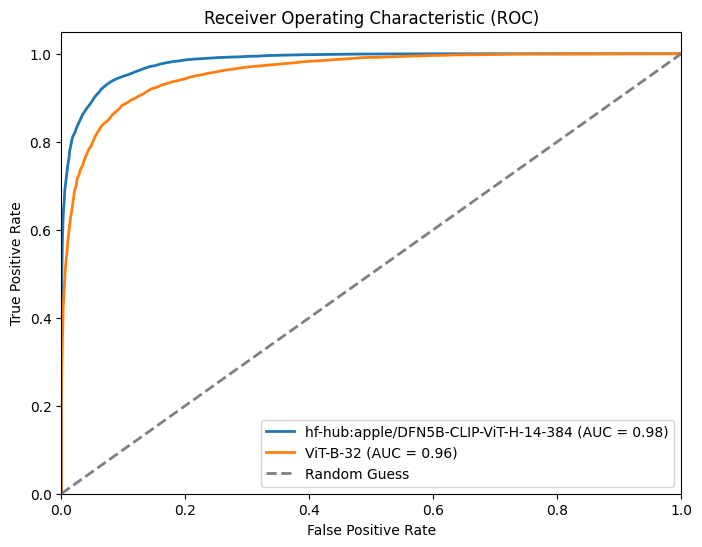

In [21]:
from sklearn.metrics import auc


plt.figure(figsize=(8, 6))
for label, results in results_curves.items():
    # Extract FPR and TPR for each threshold.
    # Note: Sorting the thresholds ensures the curve is plotted in order.
    thresholds = sorted(results.keys())

    tpr_list = np.array([results[t].recall() for t in thresholds])
    fpr_list = np.array([results[t].fpr() for t in thresholds])
    f1_scores = np.array([results[t].f1() for t in thresholds])

    print(f"Thresholds: {len(thresholds)}")
    print(f"TPR: {len(tpr_list)}")
    print(f"FPR: {len(fpr_list)}")
    print(f"Best F1 score: {np.max(f1_scores)}")
    print(f"Best threshold: {thresholds[np.argmax(f1_scores)]}")
    
    if has_violations(fpr_list, True):
        print(f"Violations found for FPR list {label}")
    if has_violations(tpr_list, True):
        print(f"Violations found for TPR list {label}")
    
    # Calculate the area under the ROC curve.
    roc_auc = auc(fpr_list, tpr_list)
    
    plt.plot(fpr_list, tpr_list, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()